In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score, recall_score

import copy
import torch
import torch.nn as nn
from torch.optim import NAdam
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Reading the dataset

In [2]:
diabetes=pd.read_csv('diabetes.csv')

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The dataset has the following features:
- Pregnancies
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI
- DiabetesPedigreeFunction
- Age

In [4]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
diabetes_x = diabetes.drop("Outcome", axis=1)
diabetes_y = diabetes["Outcome"]

Exploratory Data Analysis

In [6]:
diabetes_x.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


/tmp/ipykernel_19576/2807747172.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=diabetes, palette='Set2')


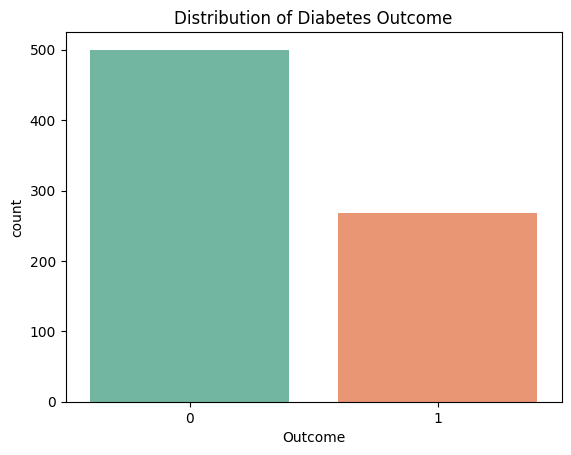

In [7]:
sns.countplot(x='Outcome', data=diabetes, palette='Set2')
plt.title("Distribution of Diabetes Outcome")
plt.show()

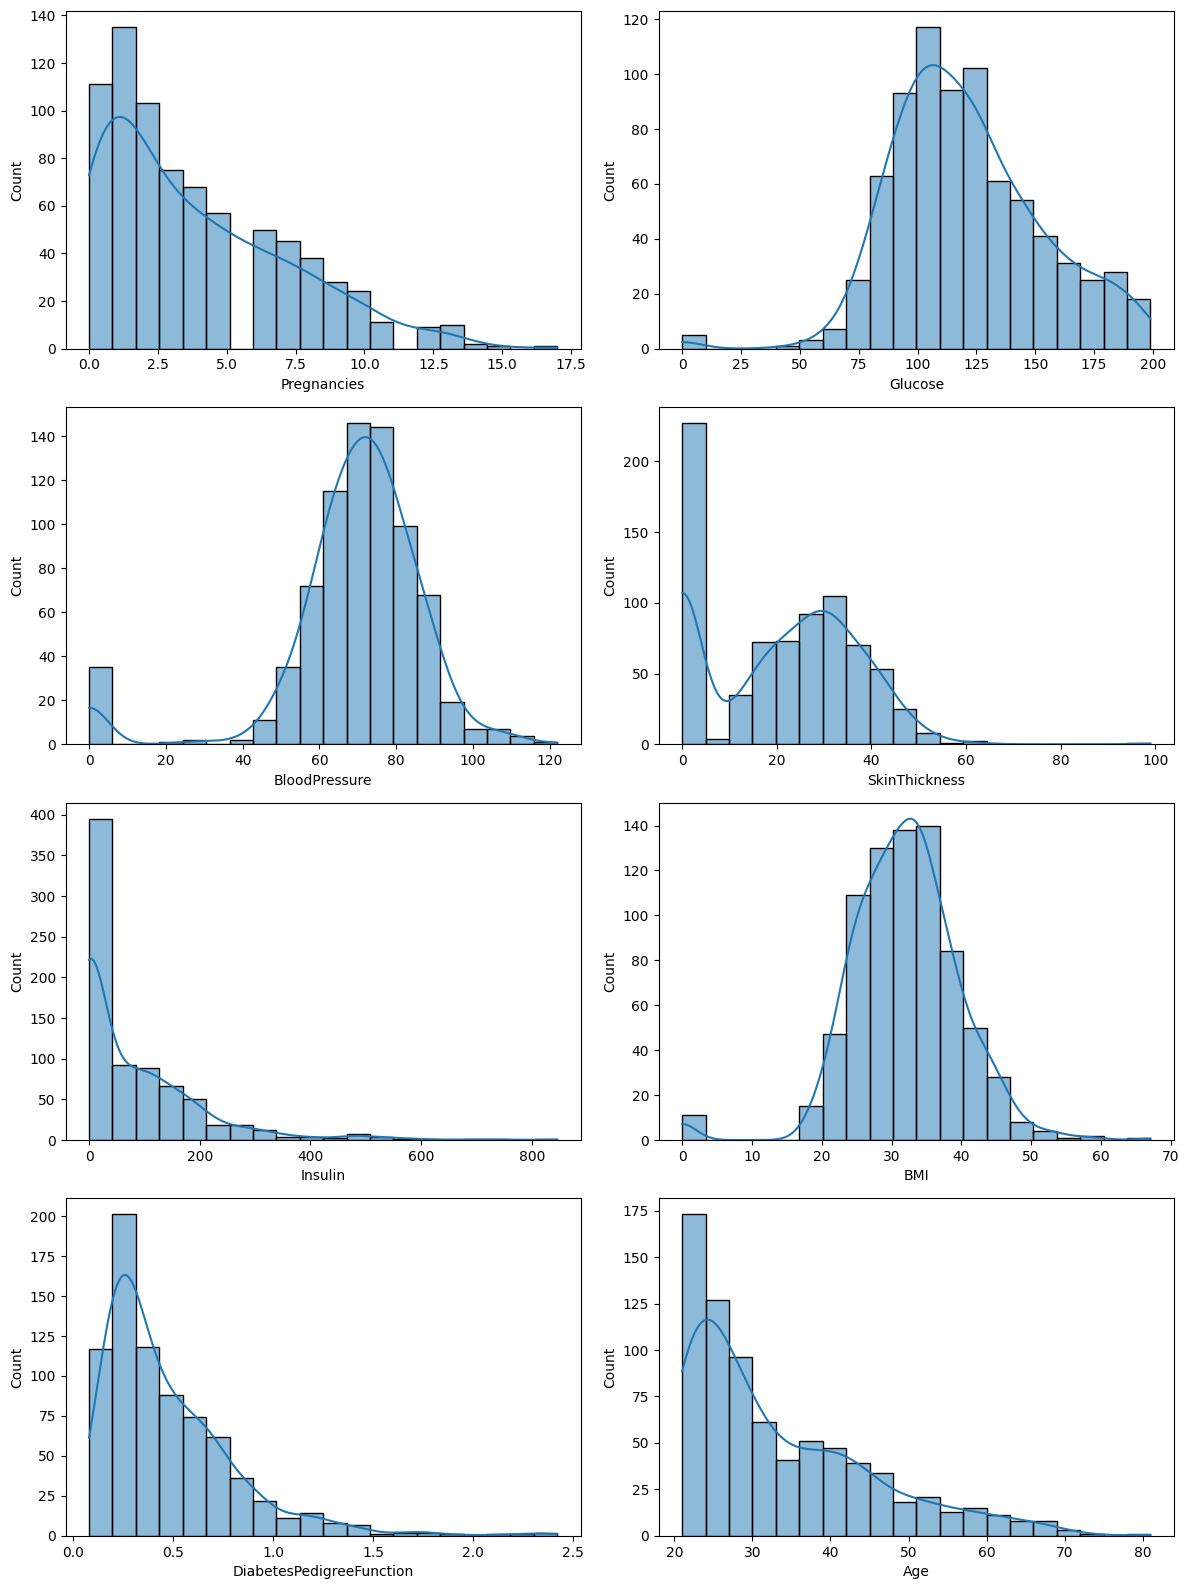

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
for col in diabetes_x.columns:
    sns.histplot(data=diabetes_x, x=col, kde=True, ax=axes.flatten()[diabetes_x.columns.get_loc(col)], bins=20)
plt.tight_layout()
plt.show()

In [9]:
rand_sampler = RandomOverSampler(sampling_strategy=1.0, random_state=42)

In [10]:
diabetes_x_resampled, diabetes_y_resampled = rand_sampler.fit_resample(diabetes_x, diabetes_y)

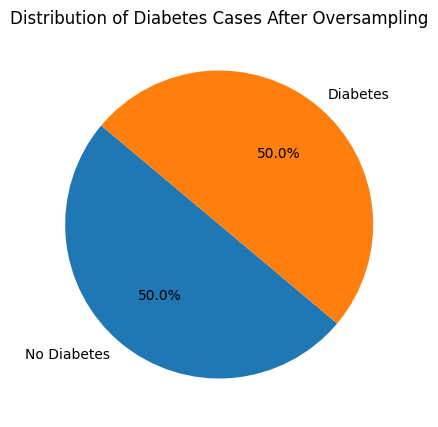

In [11]:
plt.figure(figsize=(9, 5))
plt.pie(diabetes_y_resampled.value_counts(), labels=["No Diabetes", "Diabetes"], autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Diabetes Cases After Oversampling")
plt.show()

In [12]:
print("Balanced dataset:")
print(f"Positive cases:{diabetes_x_resampled[diabetes_y_resampled == 1].shape[0]}\n Negative cases:{diabetes_x_resampled[diabetes_y_resampled == 0].shape[0]}")

Balanced dataset:
Positive cases:500
 Negative cases:500


In [13]:
diabetes_x_resampled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
995,1,122,64,32,156,35.1,0.692,30
996,0,131,0,0,0,43.2,0.270,26
997,8,120,0,0,0,30.0,0.183,38
998,4,111,72,47,207,37.1,1.390,56


In [14]:
diabetes_combined=pd.concat([diabetes_x_resampled,diabetes_y_resampled],axis=1)

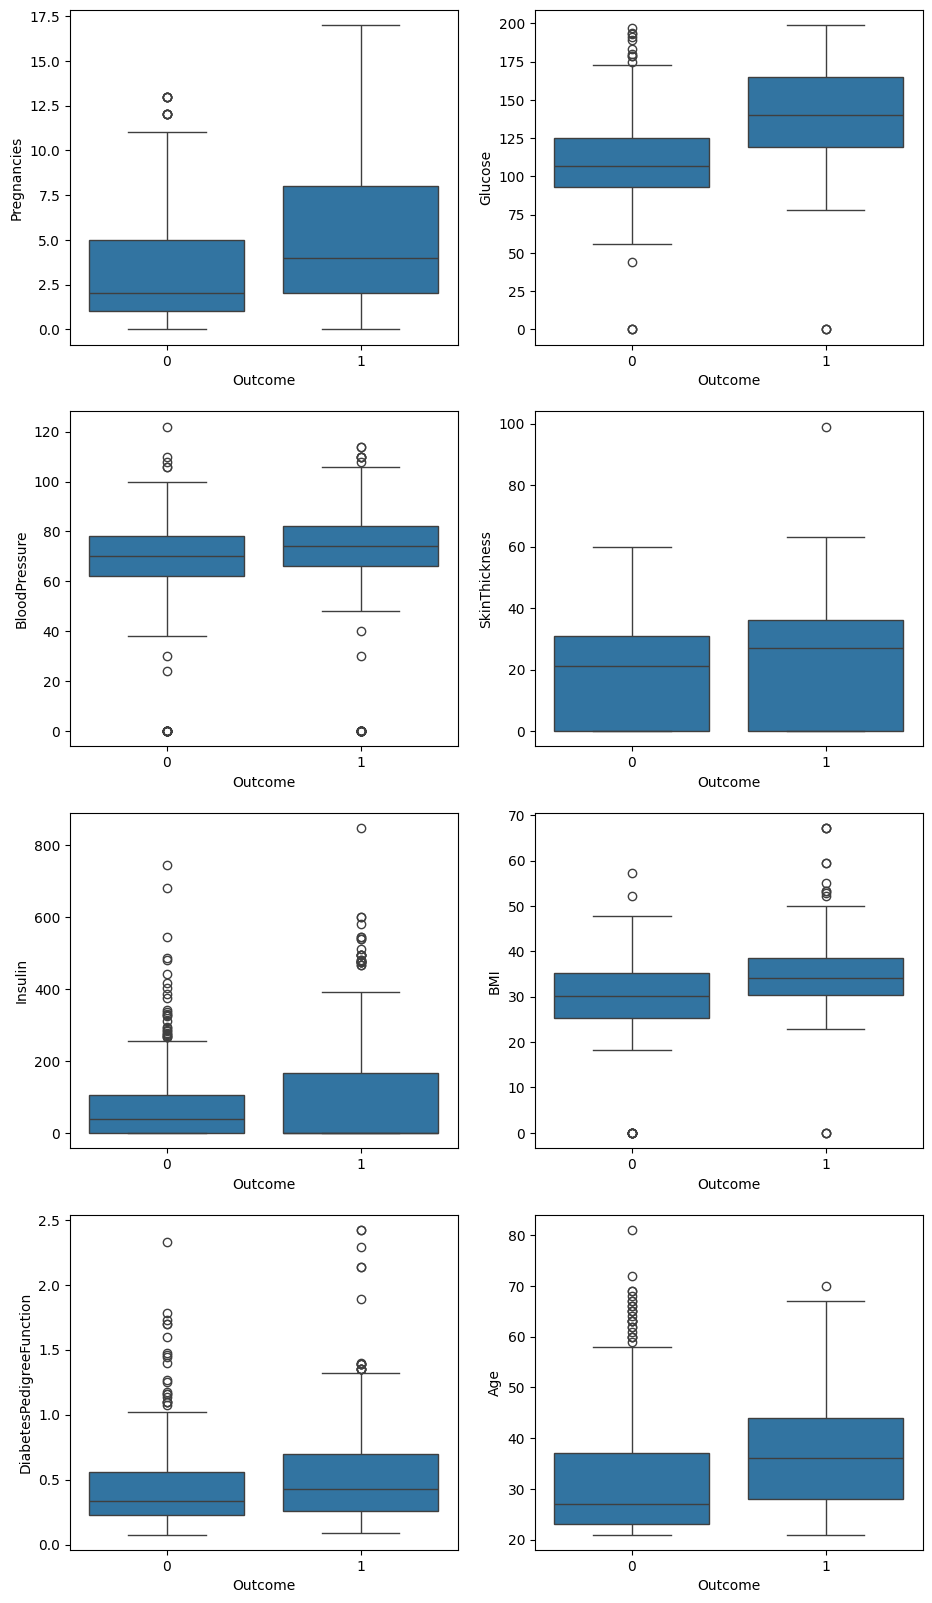

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 20))
for i, col in enumerate(diabetes_combined.columns[:-1]):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data=diabetes_combined, x="Outcome", y=col, ax=ax)

In [16]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[(df[col] < lower_bound)] = pd.NA
        df[(df[col] > upper_bound)] = pd.NA
    return df

In [17]:
diabetes_x_resampled = remove_outliers(diabetes_x_resampled, diabetes_x_resampled.columns)

In [18]:
combined_df = pd.concat([diabetes_x_resampled, diabetes_y_resampled], axis=1)

In [19]:
combined_df.dropna(inplace=True)

In [20]:
diabetes_x = combined_df.drop("Outcome", axis=1)
diabetes_y = combined_df["Outcome"]

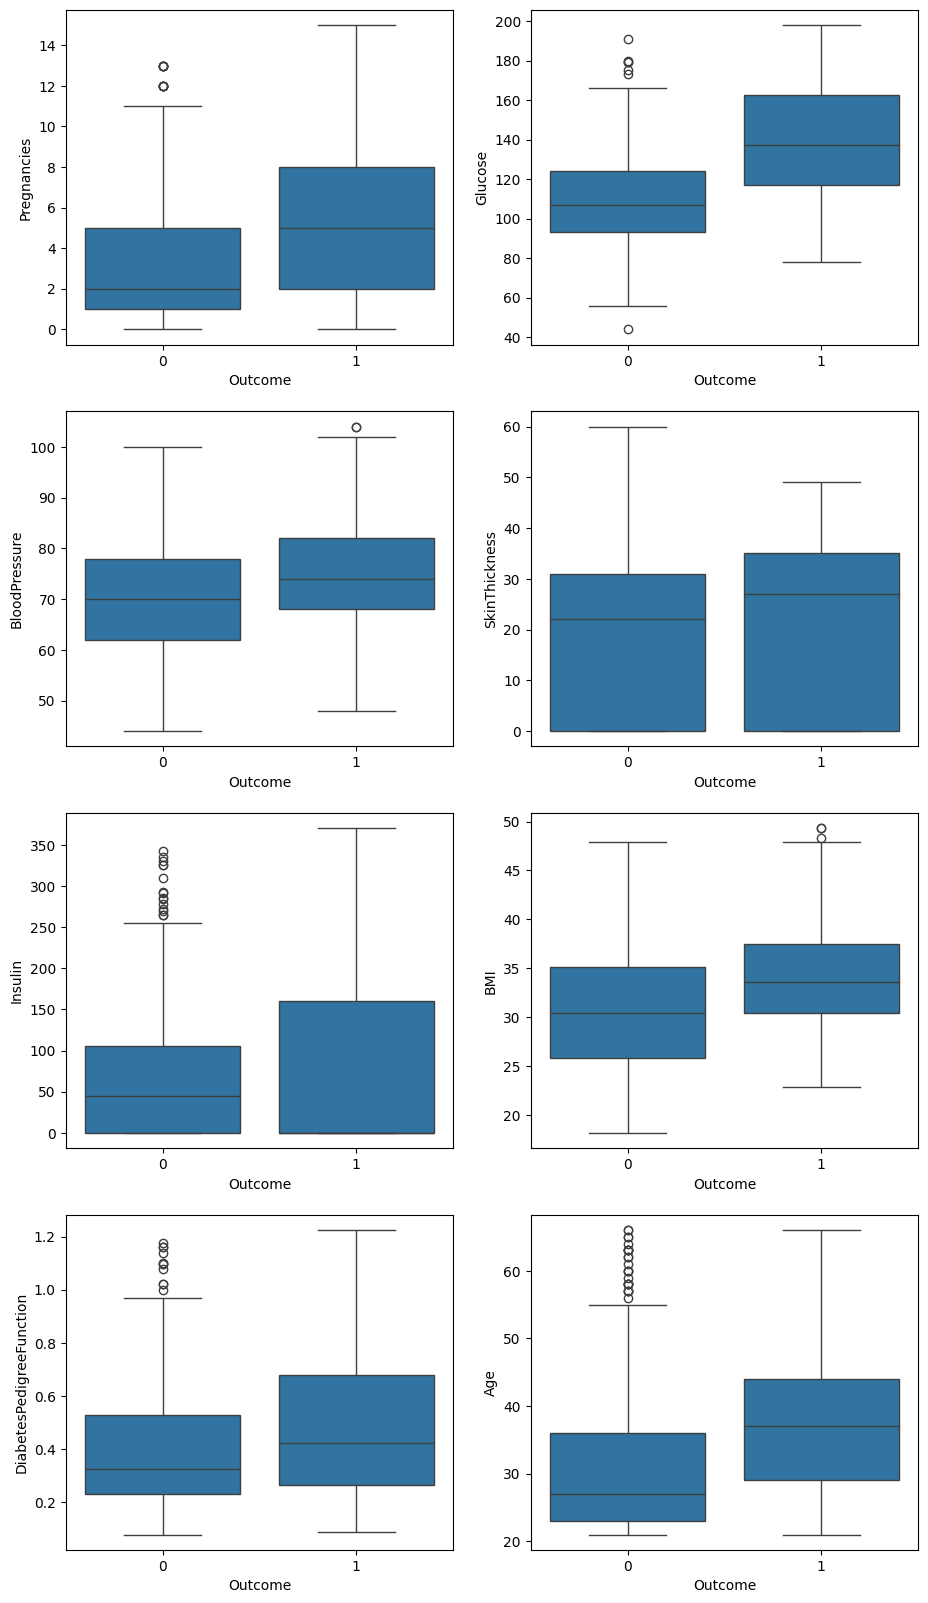

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 20))
for i, col in enumerate(diabetes_x.columns):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data=diabetes_x, x=diabetes_y, y=col, ax=ax)



In [22]:
print(f"After removing outliers, there are {diabetes_x.shape[0]} samples left.")
print(f"There are {diabetes_x[diabetes_y == 1].shape[0]} positive cases and {diabetes_x[diabetes_y== 0].shape[0]} negative cases")

After removing outliers, there are 835 samples left.
There are 394 positive cases and 441 negative cases


Correlation matrix of balanced dataset

<Axes: >

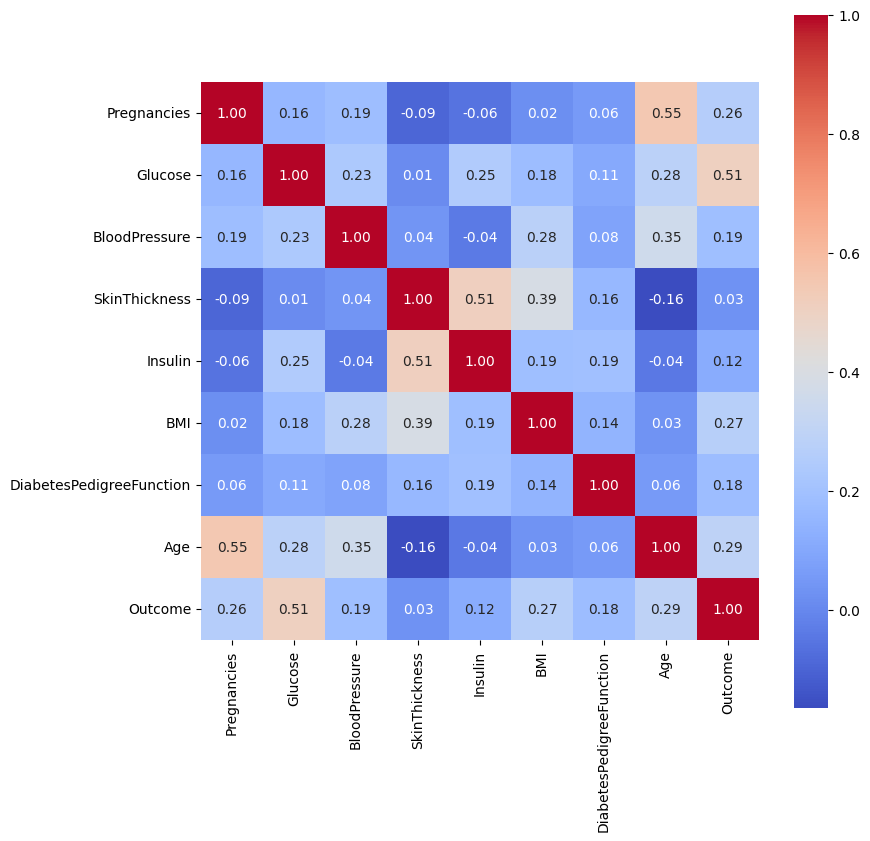

In [23]:
corr = combined_df.corr()
plt.figure(figsize=(9, 9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)

In [24]:
scaler = StandardScaler()
diabetes_X_scaled = scaler.fit_transform(diabetes_x)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(diabetes_X_scaled, diabetes_y, test_size=0.2, random_state=42)

Training a Random Forest Classifier on the balanced dataset

In [26]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Training a Multi-Layer Perceptron on the balanced dataset

In [80]:
class DiabetesModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=14, output_size=1):
        super(DiabetesModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return x

In [81]:
torch.manual_seed(42)
nn_model_01 = DiabetesModel()
nn_model_01
nn_model_01.to(device=device)

DiabetesModel(
  (fc1): Linear(in_features=8, out_features=14, bias=True)
  (fc2): Linear(in_features=14, out_features=14, bias=True)
  (out): Linear(in_features=14, out_features=1, bias=True)
)

We are using cross entropy loss for calculating the loss of the model, and NADAM for optimizing the weights and biases of the model

In [82]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = NAdam(nn_model_01.parameters(), lr=0.01)

In [83]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, device=device).view(-1, 1)

Training the neural network on the balanced dataset

In [84]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 6

train_loss_list = []
test_loss_list = []

train_accuracy_list = []
test_accuracy_list = []

for i in range(epochs):
    # train_loss = 0.0
    nn_model_01.train()

    outputs = nn_model_01(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    train_loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    nn_model_01.eval()
    with torch.no_grad():
        outputs = nn_model_01(X_test_tensor)
        outputs_train = nn_model_01(X_train_tensor)
        test_loss = loss_fn(outputs, y_test_tensor)
        test_loss_list.append(test_loss.item())
    y_pred = torch.sigmoid(outputs).round()
    y_pred_train = torch.sigmoid(outputs_train).round()

    accuracy = (y_pred == y_test_tensor).float().mean().item()
    test_accuracy_list.append(accuracy)
    train_accuracy = (y_pred_train == y_train_tensor).float().mean().item()
    train_accuracy_list.append(train_accuracy)

    if test_loss < best_model_loss:
        best_model_loss = test_loss
        best_model_weights = copy.deepcopy(nn_model_01.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i+1}")
            break
    print(f"Epoch {i+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {test_loss.item():.4f}")


Epoch 1/1000, Train Loss: 0.6923, Val Loss: 0.6869
Epoch 2/1000, Train Loss: 0.6869, Val Loss: 0.6823
Epoch 3/1000, Train Loss: 0.6820, Val Loss: 0.6764
Epoch 4/1000, Train Loss: 0.6764, Val Loss: 0.6688
Epoch 5/1000, Train Loss: 0.6694, Val Loss: 0.6588
Epoch 6/1000, Train Loss: 0.6604, Val Loss: 0.6463
Epoch 7/1000, Train Loss: 0.6490, Val Loss: 0.6315
Epoch 8/1000, Train Loss: 0.6355, Val Loss: 0.6143
Epoch 9/1000, Train Loss: 0.6199, Val Loss: 0.5949
Epoch 10/1000, Train Loss: 0.6030, Val Loss: 0.5750
Epoch 11/1000, Train Loss: 0.5853, Val Loss: 0.5558
Epoch 12/1000, Train Loss: 0.5682, Val Loss: 0.5389
Epoch 13/1000, Train Loss: 0.5522, Val Loss: 0.5242
Epoch 14/1000, Train Loss: 0.5377, Val Loss: 0.5100
Epoch 15/1000, Train Loss: 0.5244, Val Loss: 0.4983
Epoch 16/1000, Train Loss: 0.5125, Val Loss: 0.4879
Epoch 17/1000, Train Loss: 0.5018, Val Loss: 0.4791
Epoch 18/1000, Train Loss: 0.4919, Val Loss: 0.4711
Epoch 19/1000, Train Loss: 0.4831, Val Loss: 0.4650
Epoch 20/1000, Train 

Training a Support Vector Machine on the balanced dataset

In [85]:
svc_model = SVC(random_state=42, kernel='rbf')

In [86]:
svc_model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Testing the models on the test set

Random Forest Classifier

In [87]:
y_pred_01 = rf_model.predict(X_test)

Mutli-Layer Perceptron

In [88]:
nn_model_01.to(device="cpu")
nn_model_01.load_state_dict(best_model_weights)
nn_model_01.eval()

X_test_tensor = X_test_tensor.to(device="cpu")

with torch.no_grad():
    outputs = nn_model_01(X_test_tensor)
    y_pred_02 = torch.sigmoid(outputs).round().numpy()

Support Vector Machine

In [89]:
y_pred_03 = svc_model.predict(X_test)

Finding the accuracy of the three models

In [90]:
accuracy_rf = accuracy_score(y_test, y_pred_01)
accuracy_mlp = accuracy_score(y_test, y_pred_02)
accuracy_svc = accuracy_score(y_test, y_pred_03)


print(f"Random Forest Classifier Accuracy: {accuracy_rf:.4f}")
print(f"Multi-Layer Perceptron Accuracy: {accuracy_mlp:.4f}")
print(f"Support Vector Machine Accuracy: {accuracy_svc:.4f}")

Random Forest Classifier Accuracy: 0.8802
Multi-Layer Perceptron Accuracy: 0.8443
Support Vector Machine Accuracy: 0.8084


Calculating the confusion matrix of the three models

In [91]:
conf_mat_rf = confusion_matrix(y_test, y_pred_01)
conf_mat_mlp = confusion_matrix(y_test, y_pred_02)
conf_mat_svc = confusion_matrix(y_test, y_pred_03)

Visualizing the confusion matrices using a heatmap

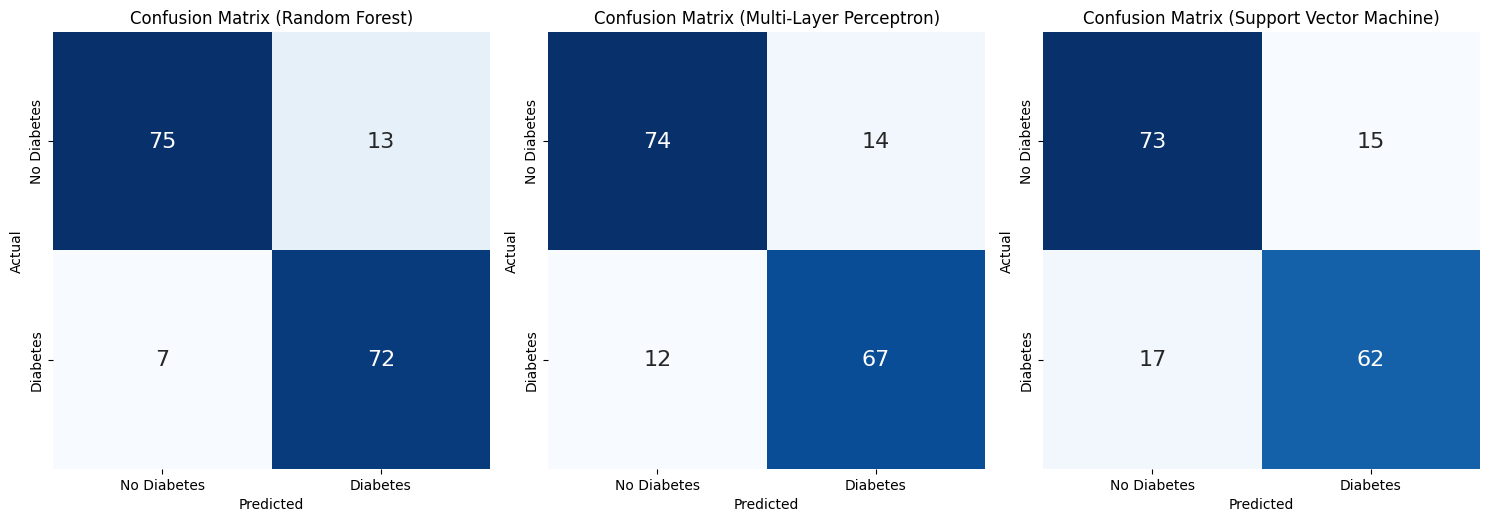

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, conf_mat, title in zip(axes, [conf_mat_rf, conf_mat_mlp, conf_mat_svc], ["Random Forest", "Multi-Layer Perceptron", "Support Vector Machine"]):
    sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"], square=True, ax=ax, cbar=False)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix ({title})")
plt.tight_layout()
plt.show()

Classification Reports of the three models

In [93]:
class_report_rf = classification_report(y_test, y_pred_01, target_names=["No Diabetes", "Diabetes"])
class_report_mlp = classification_report(y_test, y_pred_02, target_names=["No Diabetes", "Diabetes"])
class_report_svc = classification_report(y_test, y_pred_03, target_names=["No Diabetes", "Diabetes"])

In [94]:
print("Random Forest Classifier:\n", class_report_rf)
print("Multi-Layer Perceptron:\n", class_report_mlp)
print("Support Vector Machine:\n", class_report_svc)

Random Forest Classifier:
               precision    recall  f1-score   support

 No Diabetes       0.91      0.85      0.88        88
    Diabetes       0.85      0.91      0.88        79

    accuracy                           0.88       167
   macro avg       0.88      0.88      0.88       167
weighted avg       0.88      0.88      0.88       167

Multi-Layer Perceptron:
               precision    recall  f1-score   support

 No Diabetes       0.86      0.84      0.85        88
    Diabetes       0.83      0.85      0.84        79

    accuracy                           0.84       167
   macro avg       0.84      0.84      0.84       167
weighted avg       0.84      0.84      0.84       167

Support Vector Machine:
               precision    recall  f1-score   support

 No Diabetes       0.81      0.83      0.82        88
    Diabetes       0.81      0.78      0.79        79

    accuracy                           0.81       167
   macro avg       0.81      0.81      0.81       1

Plotting the train-test loss and train-test accuracy curves of the MLP

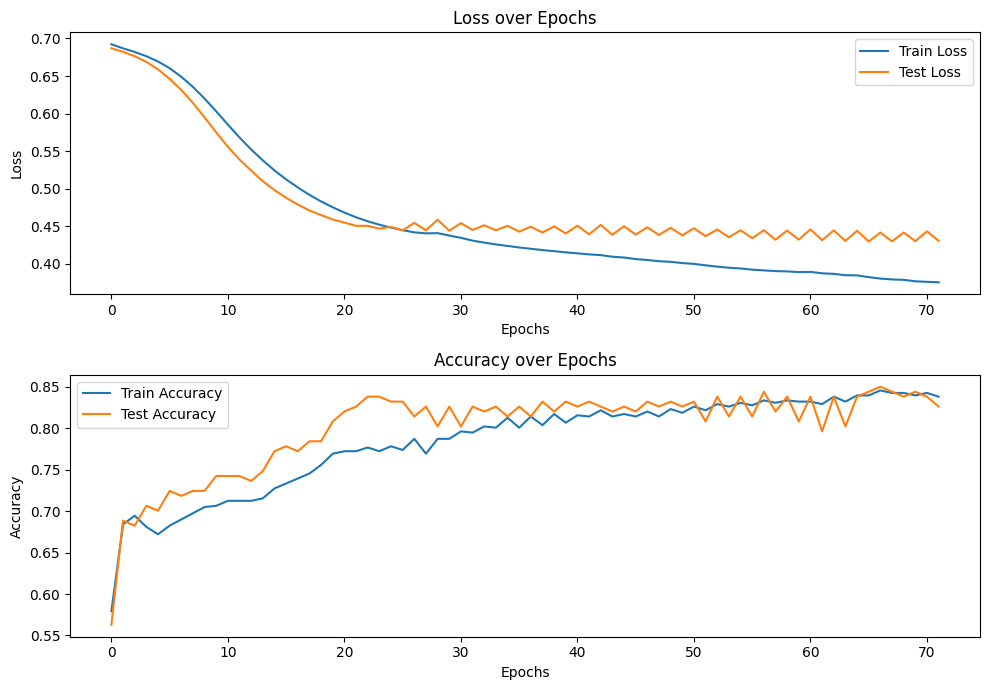

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
axes[0].plot(train_loss_list, label='Train Loss')
axes[0].plot(test_loss_list, label='Test Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(train_accuracy_list, label='Train Accuracy')
axes[1].plot(test_accuracy_list, label='Test Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()

Plotting the ROC curves of the trained models

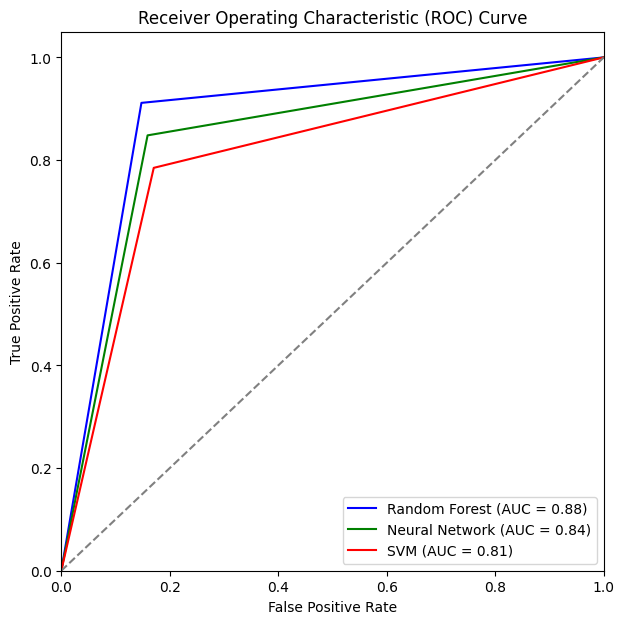

In [100]:
plt.figure(figsize=(7, 7))

fpr1, tpr1, _ = roc_curve(y_test, y_pred_01)
fpr2, tpr2, _ = roc_curve(y_test, y_pred_02)
fpr3, tpr3, _ = roc_curve(y_test, y_pred_03)

roc_auc_rf = auc(fpr1, tpr1)
roc_auc_nn = auc(fpr2, tpr2)
roc_auc_svc = auc(fpr3, tpr3)

plt.plot(fpr1, tpr1, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr2, tpr2, color='green', label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot(fpr3, tpr3, color='red', label=f'SVM (AUC = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [104]:
nn_model_01.eval()
with torch.no_grad():
    outputs = nn_model_01(X_test_tensor)
    y_pred = torch.sigmoid(outputs).round().numpy()

results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Neural Network', 'SVM'],
    'Accuracy': [accuracy_rf, accuracy_mlp, accuracy_svc],
    'F1 Score': [f1_score(y_test, y_pred_01), f1_score(y_test, y_pred_02), f1_score(y_test, y_pred_03)],
    'Precision': [precision_score(y_test, y_pred_01), precision_score(y_test, y_pred_02), precision_score(y_test, y_pred_03)],
    'Recall': [recall_score(y_test, y_pred_01), recall_score(y_test, y_pred_02), recall_score(y_test, y_pred_03)],
    'AUC': [roc_auc_rf, roc_auc_nn, roc_auc_svc]
    })

In [105]:
results_df

,Model,Accuracy,F1 Score,Precision,Recall,AUC
0,Random Forest,0.880240,0.878049,0.847059,0.911392,0.881833
1,Neural Network,0.844311,0.837500,0.827160,0.848101,0.844505
2,SVM,0.808383,0.794872,0.805195,0.784810,0.807178
